In [1]:
import torch
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib.animation as animation

### Import Data 

In [2]:
data = sio.loadmat('/Users/florian/Documents/github/Navier_Stokes_PINN/data/cylinder_nektar_wake.mat')

In [3]:
U_star = data['U_star'] # N x 2 x T
p_star = data['p_star'] # N x 2 x T
t_star = data ['t'] # T x 1
X_star = data['X_star'] # N x 2 

N = X_star.shape[0] # 5000
T = t_star.shape[0] # 200

### Format data

In [4]:
x_test = X_star[:, 0:1]
y_test = X_star[:, 1:2]
p_test = p_star[:, 0:1]
u_test = U_star[:, 0:1, 0]
t_test = np.ones((x_test.shape[0], x_test.shape[1]))

In [5]:
XX = np.tile(X_star[:, 0:1], (1, T))  # N x T
YY = np.tile(X_star[:, 1:2], (1, T))  # N x T
TT = np.tile(t_star, (1, N)).T  # N x T

UU = U_star[:, 0, :]  # N x T
VV = U_star[:, 1, :]  # N x T
PP = p_star  # N x T

x = XX.flatten()[:, None]  # NT x 1
y = YY.flatten()[:, None]  # NT x 1
t = TT.flatten()[:, None]  # NT x 1

u = UU.flatten()[:, None]  # NT x 1
v = VV.flatten()[:, None]  # NT x 1
p = PP.flatten()[:, None]  # NT x 1

### Select Train and Test data and add noise 

In [6]:
np.random.seed(42)
torch.manual_seed(42)

In [7]:
# Noiseless data
N_train = 5000
idx = np.random.choice(N*T, N_train, replace=False)
x_train = x[idx,:] # 5000 x 1
y_train = y[idx,:]
t_train = t[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]

In [8]:
# Noisy data
noise = 0.01        
u_train = u_train + noise*np.std(u_train)*np.random.randn(u_train.shape[0], u_train.shape[1])
v_train = v_train + noise*np.std(v_train)*np.random.randn(v_train.shape[0], v_train.shape[1])

### Model

In [9]:
class PINN():


    def __init__(self, x, y, t, u, v):
        
        self.x = torch.tensor(x, dtype=torch.float32, requires_grad=True)
        self.y = torch.tensor(y, dtype=torch.float32, requires_grad=True)
        self.t = torch.tensor(t, dtype=torch.float32, requires_grad=True)
        self.u = torch.tensor(u, dtype=torch.float32, requires_grad=True)
        self.v = torch.tensor(v, dtype=torch.float32, requires_grad=True)


        self.null = torch.zeros_like(self.x)

        self.neuralnet()

        self.optimizer = torch.optim.LBFGS(self.net.parameters(), lr= 1, max_iter= 10000, max_eval= 5000, history_size= 50, line_search_fn= 'strong_wolfe', tolerance_change= 0.5* np.finfo(float).eps, tolerance_grad= 1e-05)

        self.mse = torch.nn.MSELoss()
        self.loss = 0 
        self.iter = 0


    def neuralnet(self):

        self.net = torch.nn.Sequential(
            torch.nn.Linear(3, 20), torch.nn.Tanh(),
            torch.nn.Linear(20, 20), torch.nn.Tanh(),
            torch.nn.Linear(20, 20), torch.nn.Tanh(),
            torch.nn.Linear(20, 20), torch.nn.Tanh(),
            torch.nn.Linear(20, 20), torch.nn.Tanh(),
            torch.nn.Linear(20, 20), torch.nn.Tanh(),
            torch.nn.Linear(20, 20), torch.nn.Tanh(),
            torch.nn.Linear(20, 20), torch.nn.Tanh(),
            torch.nn.Linear(20, 20), torch.nn.Tanh(),
            torch.nn.Linear(20, 2))
        
    def navier_stokes(self, x, y, t):
        lambda_1, lambda_2 = 1., 1.

        result = self.net(torch.cat([x, y, t], 1))
        psi, p = result[:, 0:1], result[:, 1:2]

        u = torch.autograd.grad(psi, y, torch.ones_like(x), create_graph=True)[0]
        v = -torch.autograd.grad(psi, x, torch.ones_like(y), create_graph=True)[0]

        p_x = torch.autograd.grad(p, x, torch.ones_like(x), create_graph=True)[0]
        p_y = torch.autograd.grad(p, y, torch.ones_like(y), create_graph=True)[0]

        u_t = torch.autograd.grad(u, t, torch.ones_like(t), create_graph=True)[0]
        u_x = torch.autograd.grad(u, x, torch.ones_like(x), create_graph=True)[0]
        u_y = torch.autograd.grad(u, y, torch.ones_like(y), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, torch.ones_like(x), create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, torch.ones_like(y), create_graph=True)[0]

        v_t = torch.autograd.grad(v, t, torch.ones_like(t), create_graph=True)[0]
        v_x = torch.autograd.grad(v, x, torch.ones_like(x), create_graph=True)[0]
        v_y = torch.autograd.grad(v, y, torch.ones_like(y), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, torch.ones_like(x), create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, torch.ones_like(y), create_graph=True)[0]

        f_u = u_t + lambda_1 * (u*u_x + v*u_y) + p_x - lambda_2 * (u_xx + u_yy)
        f_v = v_t + lambda_1 * (u*v_x + v*v_y) + p_y - lambda_2 * (v_xx + v_yy)

        return u, v, p, f_u, f_v
    
    def closure(self):

        self.optimizer.zero_grad()

        u_pred, v_pred, p, f_u_pred, f_v_pred = self.navier_stokes(self.x, self.y, self.t)

        loss_u = self.mse(u_pred, self.u)
        loss_v = self.mse(v_pred, self.v)
        loss_f_u = self.mse(f_u_pred, self.null)
        loss_f_v = self.mse(f_v_pred, self.null)

        self.loss = loss_u + loss_v + loss_f_u + loss_f_v

        self.loss.backward()

        self.iter += 1
        if not self.iter % 10:
            print("Iteration: {:} Loss: {:.6e}".format(self.iter, self.loss))

        return self.loss

    def train_nn(self):
        
        self.net.train()
        self.optimizer.step(self.closure)

In [28]:
N_train = 2000

pinn_navier_stokes = PINN(x_train, y_train, t_train, u_train, v_train)
pinn_navier_stokes.train_nn()

Iteration: 10 Loss: 1.289592e+00
Iteration: 20 Loss: 5.612523e-01
Iteration: 30 Loss: 2.400324e-01
Iteration: 40 Loss: 1.721743e-01
Iteration: 50 Loss: 1.601429e-01
Iteration: 60 Loss: 1.488392e-01
Iteration: 70 Loss: 1.427302e-01
Iteration: 80 Loss: 1.398024e-01
Iteration: 90 Loss: 1.374558e-01
Iteration: 100 Loss: 1.362967e-01
Iteration: 110 Loss: 1.354390e-01
Iteration: 120 Loss: 1.346114e-01
Iteration: 130 Loss: 1.341079e-01
Iteration: 140 Loss: 1.335171e-01
Iteration: 150 Loss: 1.327345e-01
Iteration: 160 Loss: 1.319545e-01
Iteration: 170 Loss: 1.313560e-01
Iteration: 180 Loss: 1.307757e-01
Iteration: 190 Loss: 1.302058e-01
Iteration: 200 Loss: 1.294555e-01
Iteration: 210 Loss: 1.289577e-01
Iteration: 220 Loss: 1.283411e-01
Iteration: 230 Loss: 1.279792e-01
Iteration: 240 Loss: 1.269784e-01
Iteration: 250 Loss: 1.266710e-01
Iteration: 260 Loss: 1.262839e-01
Iteration: 270 Loss: 1.259742e-01
Iteration: 280 Loss: 1.256795e-01
Iteration: 290 Loss: 1.253727e-01
Iteration: 300 Loss: 1.

In [2]:
torch.save(pinn_navier_stokes.net.state_dict(), 'pinn_navier_stokes1.pth')

NameError: name 'torch' is not defined

In [10]:
pinn = PINN(x_train, y_train, t_train, u_train, v_train)
pinn.net.load_state_dict(torch.load('/Users/florian/Documents/github/Navier_Stokes_PINN/main/pinn_navier_stokes1.pth'))
pinn.net.eval()

Sequential(
  (0): Linear(in_features=3, out_features=20, bias=True)
  (1): Tanh()
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): Tanh()
  (4): Linear(in_features=20, out_features=20, bias=True)
  (5): Tanh()
  (6): Linear(in_features=20, out_features=20, bias=True)
  (7): Tanh()
  (8): Linear(in_features=20, out_features=20, bias=True)
  (9): Tanh()
  (10): Linear(in_features=20, out_features=20, bias=True)
  (11): Tanh()
  (12): Linear(in_features=20, out_features=20, bias=True)
  (13): Tanh()
  (14): Linear(in_features=20, out_features=20, bias=True)
  (15): Tanh()
  (16): Linear(in_features=20, out_features=20, bias=True)
  (17): Tanh()
  (18): Linear(in_features=20, out_features=2, bias=True)
)

/var/folders/fm/5lbdpfj928d6sqhy_19cp6ww0000gn/T/ipykernel_38451/4041027155.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True)
/var/folders/fm/5lbdpfj928d6sqhy_19cp6ww0000gn/T/ipykernel_38451/4041027155.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32, requires_grad=True)
/var/folders/fm/5lbdpfj928d6sqhy_19cp6ww0000gn/T/ipykernel_38451/4041027155.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t_test = torch.ten

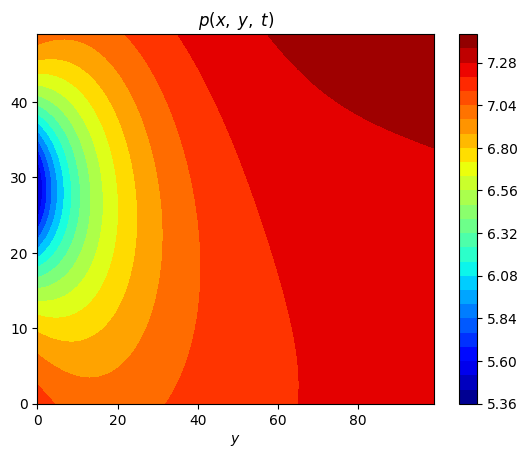

In [25]:
x_test = torch.tensor(x_test, dtype=torch.float32, requires_grad=True)
y_test = torch.tensor(y_test, dtype=torch.float32, requires_grad=True)
t_test = torch.tensor(t_test, dtype=torch.float32, requires_grad=True)  

u_out, v_out, p_out, f_u_out, f_v_out = pinn.navier_stokes(x_test, y_test, t_test)

u_plot = p_out.data.cpu().numpy()
u_plot = np.reshape(u_plot, (50, 100))

fig, ax = plt.subplots()

plt.contourf(u_plot, levels=30, cmap='jet')
plt.colorbar()

from IPython.display import HTML

def animate(i):
    ax.clear()
    u_out, v_out, p_out, f_out, g_out = pinn.navier_stokes(x_test, y_test, i*t_test)
    u_plot = p_out.data.cpu().numpy()
    u_plot = np.reshape(u_plot, (50, 100))
    cax = ax.contourf(u_plot, levels=20, cmap='jet')
    plt.xlabel(r'$x$')
    plt.xlabel(r'$y$')
    plt.title(r'$p(x,\; y, \; t)$')

# Call animate method
ani = animation.FuncAnimation(fig, animate, frames=100, interval=1, blit=False)
out = HTML(ani.to_jshtml())

In [26]:
out